# Compare Time DOmaiin Survey and VASCA catalogs

In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

### Load VASCA region

In [2]:
region_name = "TDS_ELAISN1"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6


### Get TDS & VASCA data and match them positionally

In [3]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796
#sel_vasca( = rg.tt_sources["flux_cpval"]<0.000000573303) * (rg.tt_sources["flux_cpval"]>-0.5)
#rg.tt_sources["sel"][:]=sel_vasca
sel_vasca = rg.tt_sources["sel"]
tt_vasca = rg.tt_sources[sel_vasca]

#Read TDS
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all[sel_elai] #tt_tds_all #
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

match_dist = 10 * uu.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

display(tt_vasca[:2])
display(tt_tds[:2])

fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel,rg_fd_id,rg_src_id,nr_fd_srcs,tds_recno,tds_idx,tds_dist,tds_match
,,,deg,deg,deg,deg2,deg2,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,,,,,,,arcsec,
int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32,int32,int64,float64,bool
-1,47,0,244.20601109436407,54.706400437091,3.0230929e-05,1.3489577e-12,3.4029092e-08,4.433864e-07,238.13632,0.4400468,0.00038214022,31.082472,5.023708e-13,3.271414,13.867767,4.188016,11.466827,-0.069216505,17.957935,0.0020046234,True,-1,64,2,938,146,296.74335891687235,False
-1,37,0,243.83814357242593,55.08296090177889,3.6447345e-05,1.0906565e-12,6.709201e-08,4.3078795e-21,197.40013,0.4771283,0.0004870827,27.650963,2.1304043e-09,3.0512094,13.5794525,3.9251878,13.5794525,0.2879905,18.161633,0.0026226044,True,-1,141,2,630,99,124.07293635467916,False


recno,ID,ra,dec,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class,rg_src_id,vasca_idx,vasca_dist,vasca_match
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,,,,arcsec,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12,int32,int64,float64,bool
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV,2452,30,0.4675,True
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans,48618,310,1.5425,True


In [4]:
sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))
print("Nr. associated sources VASCA/TDS:",sel_vmt.sum(),"/",sel_tmv.sum())
print("Fraction of associated VASCA/TDS sources:",sel_vmt.sum()/len(tt_vasca),"/",sel_tmv.sum()/len(tt_tds))

ids_tds = tt_tds["ID"].data.astype(dtype=str)
sel_tds_mos15 = (np.char.find(ids_tds, 'MOS15') > -1)
tt_tds_mos15 = tt_tds[sel_tds_mos15]
print("Total Nr of TDS sources from MOS15:",len(tt_tds_mos15))
display(tt_tds_mos15[tt_tds_mos15["vasca_match"]==False]["recno","ID","ra","dec"])

Nr. sources VASCA/TDS : 437 / 160
Nr. associated sources VASCA/TDS: 109 / 110
Fraction of associated VASCA/TDS sources: 0.2494279176201373 / 0.6875
Total Nr of TDS sources from MOS15: 26


recno,ID,ra,dec
,,deg,deg
int32,bytes16,float64,float64
59,ELAISN1_MOS15-10,242.3832,53.6801
71,ELAISN1_MOS15-20,242.8292,53.7492
212,ELAISN1_MOS15-11,242.4293,54.3621
307,ELAISN1_MOS15-03,242.1960,54.0721
390,ELAISN1_MOS15-22,242.8843,53.5921
417,ELAISN1_MOS15-18,242.7775,53.9643
441,ELAISN1_MOS15-13,242.4726,53.6579
495,ELAISN1_MOS15-00,241.6487,54.3255


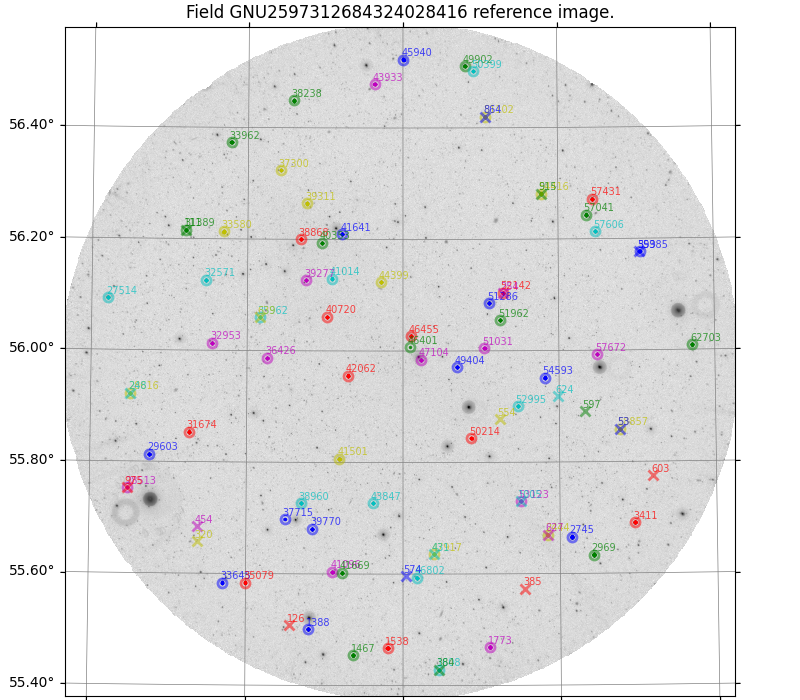

In [5]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][0]
fd = rg.get_field(field_id=field_id, load_method="FITS", add_field=False)

#from astropy.coordinates import Angle, SkyCoord
#from regions import CircleSkyRegion
#center = SkyCoord(243.0512, 54.2599, unit='deg')
#radius = Angle(0.03, 'deg')
#region = CircleSkyRegion(center, radius)

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, src_id="rg_src_id", sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

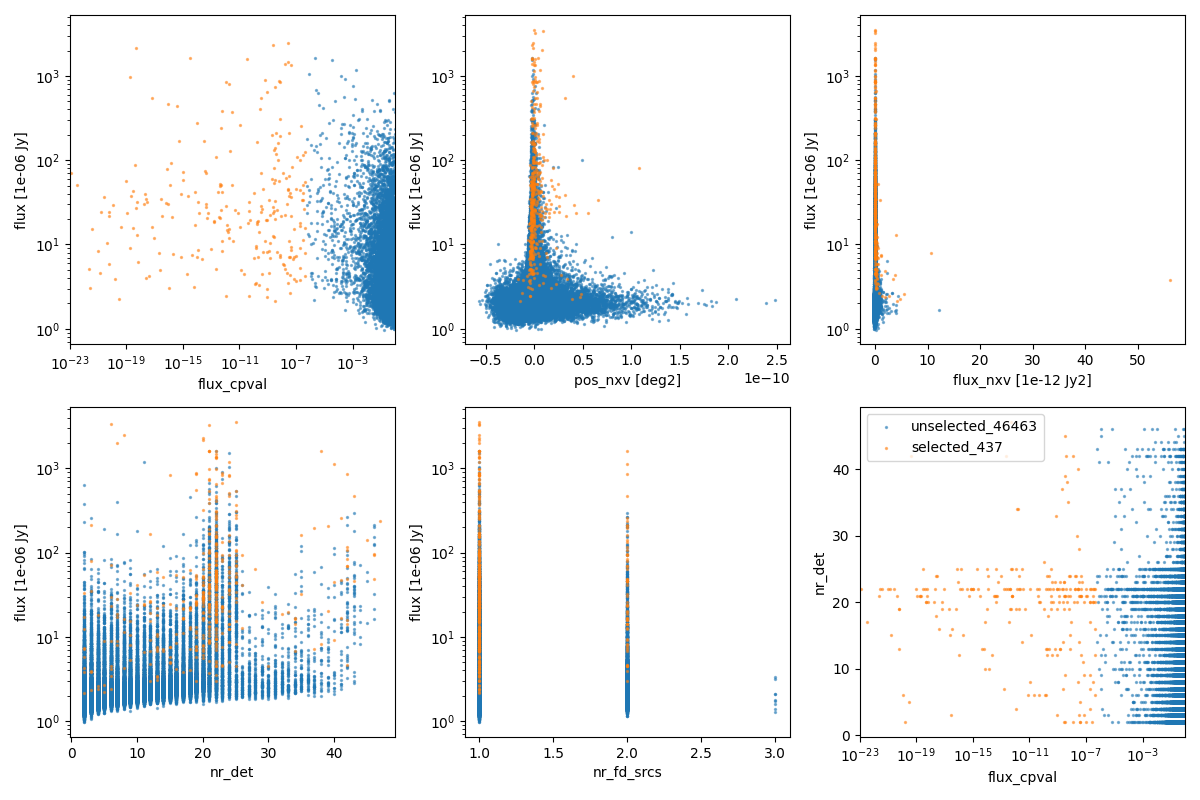

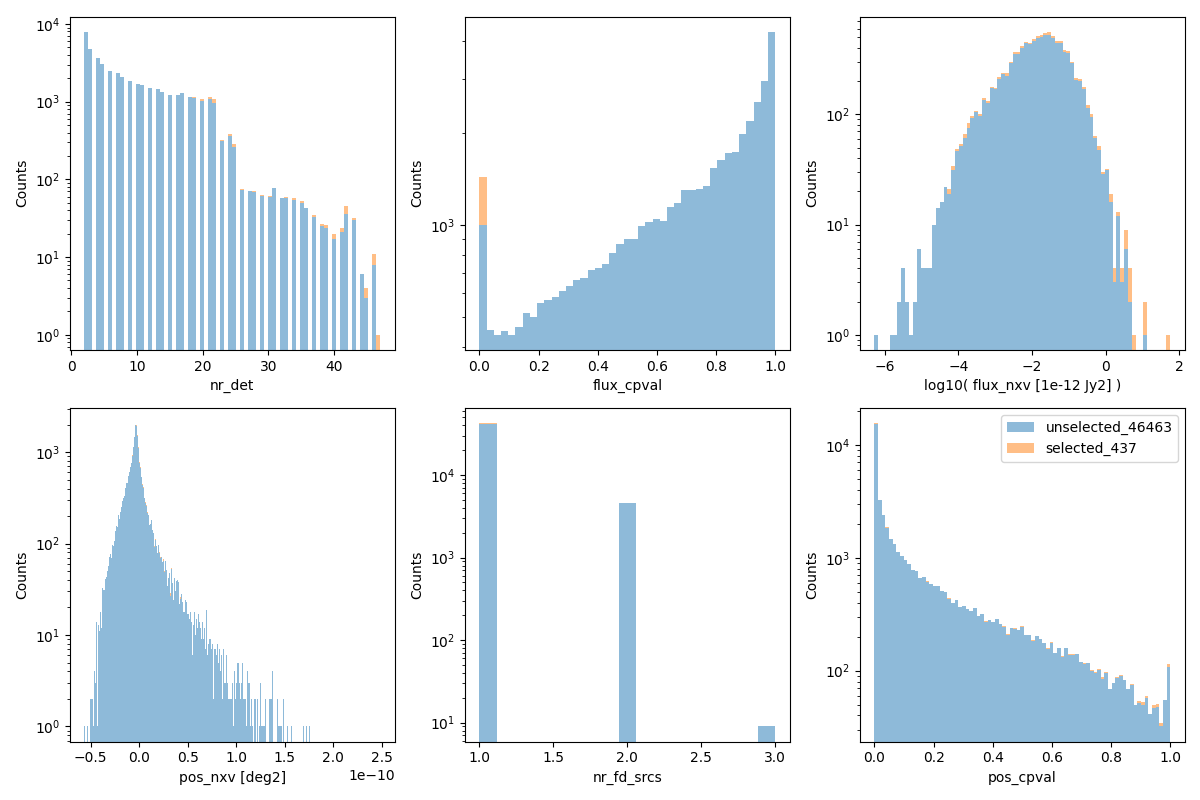

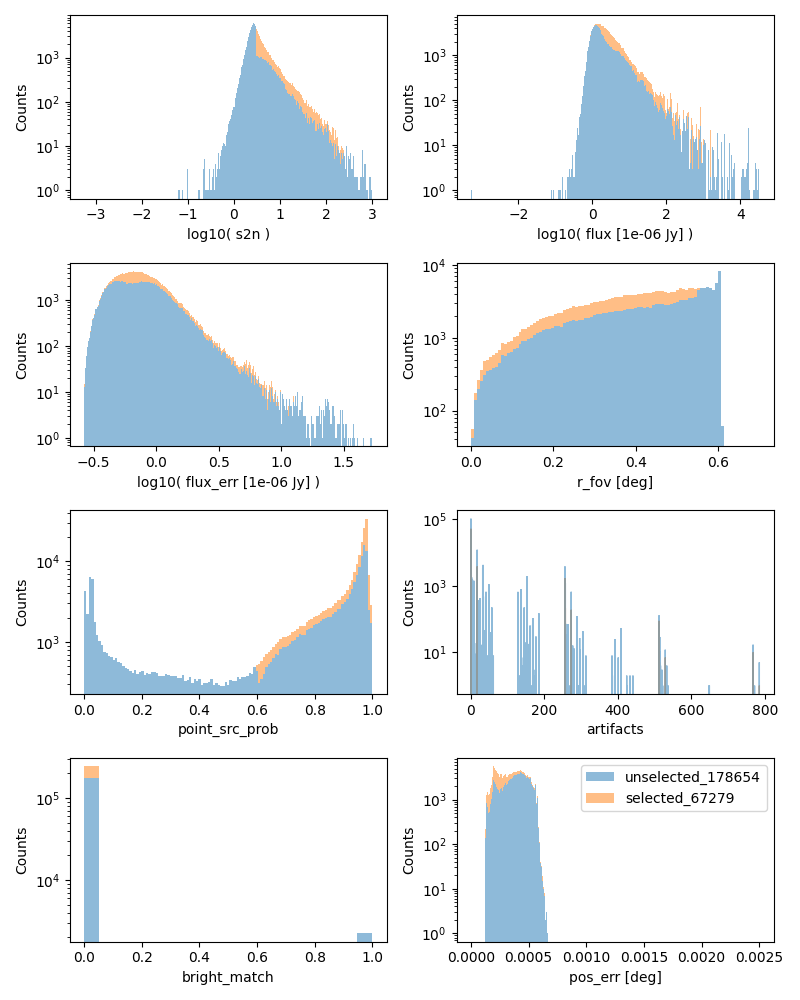

In [6]:
import vasca.visualization as vvis
fig_fd_det_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
fig_det_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist",fig_size=(8, 10))

In [7]:
#71	ELAISN1_MOS15-20	242.8292	53.7492
#307	ELAISN1_MOS15-03	242.1960	54.0721
#390	ELAISN1_MOS15-22	242.8843	53.5921
#417	ELAISN1_MOS15-18	242.7775	53.9643
#441	ELAISN1_MOS15-13	242.4726	53.6579
#495	ELAISN1_MOS15-00	241.6487	54.3255

#127	ELAISN1_MOS15-16	242.7175	53.7547



da = 0.03 #10/3600.
ra_src = 242.77
dec_src = 56.20
sel_ra = (fd.tt_detections["ra"]>ra_src-da)*(fd.tt_detections["ra"]<ra_src+da)
sel_dec = (fd.tt_detections["dec"]>dec_src-da)*(fd.tt_detections["dec"]<dec_src+da)
sel_src = sel_ra*sel_dec
display(fd.tt_detections[sel_src])
print(fd.tt_detections[sel_src]["artifacts"].data)

vis_id,fd_src_id,ra,dec,pos_err,flux,flux_err,s2n,sel,det_id,r_fov,artifacts,point_src_prob,bright_match,flux_f60,flux_f60_err,flux_f38,flux_f38_err,E_bv,mag,mag_err
,,deg,deg,deg,1e-06 Jy,1e-06 Jy,,,,deg,,,,,,,,,mag,mag
int64,int32,float64,float64,float32,float32,float32,float32,bool,int64,float32,int64,float32,int32,float32,float32,float32,float32,float32,float32,float32
2597312546683748352,3070,242.7539624843512,56.17279940921243,0.0003710951,1.8183502,0.5741204,3.1671932,True,2597312546684804125,0.23577027,0,0.9741352,0,0.04574518,0.014044184,0.03230401,0.01005415,0.008049339,23.250805,0.34289035
2597312546683748352,8721,242.79551825977939,56.17431311963295,0.00041743874,5.285116,1.4701273,3.5950058,True,2597312546684804164,0.2511715,17,0.9573086,0,0.052118756,0.014053783,0.028553452,0.009787301,0.008049339,22.092363,0.30208576
2597312546683748352,1608,242.74142587077569,56.17113927073915,0.00018695484,11.1033325,0.92994356,11.939792,True,2597312546684804165,0.2303896,0,0.9817381,0,0.288183,0.020698834,0.21825634,0.017748645,0.008049339,21.286366,0.09095636
2597312546683748352,-1,242.7911406847506,56.178551517577915,0.00026583803,5.414916,1.3310825,4.068054,False,2597312546686901370,0.25290072,17,0.38316077,0,0.098035045,0.015635476,0.056448136,0.011356376,0.008049339,22.06602,0.2669581
2597312546683748352,-1,242.78582501872538,56.18420660307302,0.00044632753,1.7350814,0.8332417,2.0823267,False,2597312546684804229,0.25551423,17,0.91764796,0,0.035353076,0.014069549,0.021698516,0.009096862,0.008049339,23.301699,0.521532
2597312546683748352,-1,242.7782616708299,56.17915929275453,0.00031170636,7.3672643,1.4647858,5.029585,False,2597312546684804238,0.24894728,17,0.23462425,0,0.083845645,0.015306949,0.055587154,0.010947147,0.008049339,21.731733,0.2159224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597312547623272448,-1,242.79877564557242,56.22249542412682,0.00027059935,1.7987882,0.61972266,2.9025695,False,2597312547624328009,0.2816348,0,0.97511137,0,0.053886082,0.017232824,0.054290455,0.012611745,0.008524975,23.262548,0.37415123


[  0  17   0  17  17  17  17   0  17   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  17   0   0  17  17  17   0   0   0  17  17   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  17  17   0  17  17  17  17  17   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 128   8 136 128 136 128 136 136 128   0 128
   0   0   0   8   0   0   0   0   0   0  17   0   0   0   0  17   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [8]:
display(fd.tt_sources[fd.tt_sources["fd_src_id"]==4474])

fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel
,,,deg,deg,deg,deg2,deg2,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,
int32,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool
4474,6,0,241.54194357998063,56.04141726524083,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,-1.0,True
